In [1]:
import os
import re
import nrrd

import numpy as np
import pandas as pd

from scipy import stats
from scipy.spatial import distance
from scipy.cluster import hierarchy

from ioutil import relative_paths

#from skimage.measure import compare_ssim as ssim

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import rcParams, cycler
from matplotlib.colors import ListedColormap

%matplotlib inline

In [2]:
patient_id = np.load('./../../data_source/patient_id.npy')

In [3]:
paths_to_ct = relative_paths('./../../data_source/images/ct_nrrd', target_format='nrrd')
paths_to_pet = relative_paths('./../../data_source/images/pet_nrrd', target_format='nrrd')
paths_to_mask = relative_paths('./../../data_source/images/masks_nrrd', target_format='nrrd')

ct = {}
pet = {}
mask = {}
ct_cropped = {}
pet_cropped = {}

for num, path_to_ct in enumerate(paths_to_ct):
    
    ct_image, _ = nrrd.read(path_to_ct)
    ct[path_to_ct] = ct_image

    pet_image, _ = nrrd.read(paths_to_pet[num])
    pet[paths_to_pet[num]] = pet_image
    
    mask_image, _ = nrrd.read(paths_to_mask[num])
    mask[paths_to_mask[num]] = mask_image
    
    ct_cropped[path_to_ct] = ct[path_to_ct] * mask_image

    pet_cropped[paths_to_pet[num]] = pet[paths_to_pet[num]] * mask_image

# GL Mean, Median, Min, Max

In [15]:
def gl_statistics(image):
    
    _image = np.copy(image)
    _image = _image[image != 0]

    return {
        'gl_mean': np.mean(_image),
        'gl_median': np.median(_image),
        'gl_min': np.min(_image),
        'gl_max': np.max(_image),
    }

In [16]:
# Complete image statistics. 
ct_stats, pet_stats = {}, {}
for num, (pet_image, ct_image) in enumerate(zip(pet.values(), ct.values())):
  
    pet_stats[num] = gl_statistics(pet_image)
    ct_stats[num] = gl_statistics(ct_image)
    
# Cropped image statistics.
ct_cropped_stats, pet_cropped_stats = {}, {}
for num, (cropped_pet_image, cropped_ct_image) in enumerate(zip(pet_cropped.values(), ct_cropped.values())):
    
    pet_cropped_stats[num] = gl_statistics(cropped_pet_image)
    ct_cropped_stats[num] = gl_statistics(cropped_ct_image)
    
    
df_ct_stats = pd.DataFrame(ct_stats)
df_ct_cropped_stats = pd.DataFrame(ct_cropped_stats)

df_pet_stats = pd.DataFrame(pet_stats)
df_pet_cropped_stats = pd.DataFrame(pet_cropped_stats)

df_ct_stats.columns = patient_id
df_ct_cropped_stats.columns = patient_id

df_pet_stats.columns = patient_id
df_pet_cropped_stats.columns = patient_id

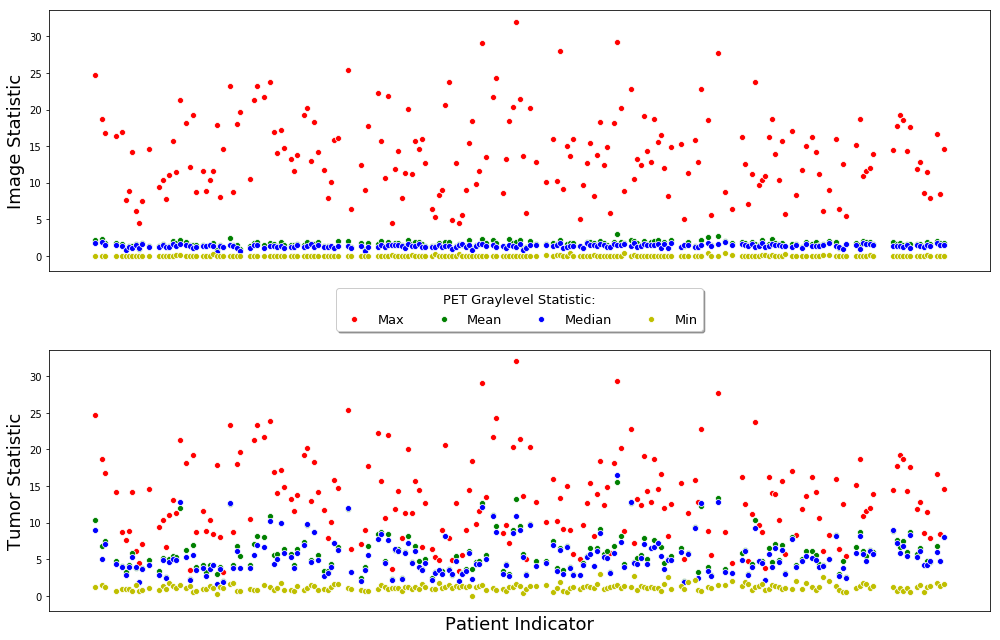

In [17]:
# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Max', 'Mean', 'Median', 'Min']
for num, (pet_cropped_row_label, pet_row_label) in enumerate(zip(df_pet_cropped_stats.T, df_pet_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_stats.columns.values), 
        y=np.squeeze(df_pet_stats.loc[pet_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_pet_cropped_stats.columns.values), 
        y=np.squeeze(df_pet_cropped_stats.loc[pet_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='PET Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './pet_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

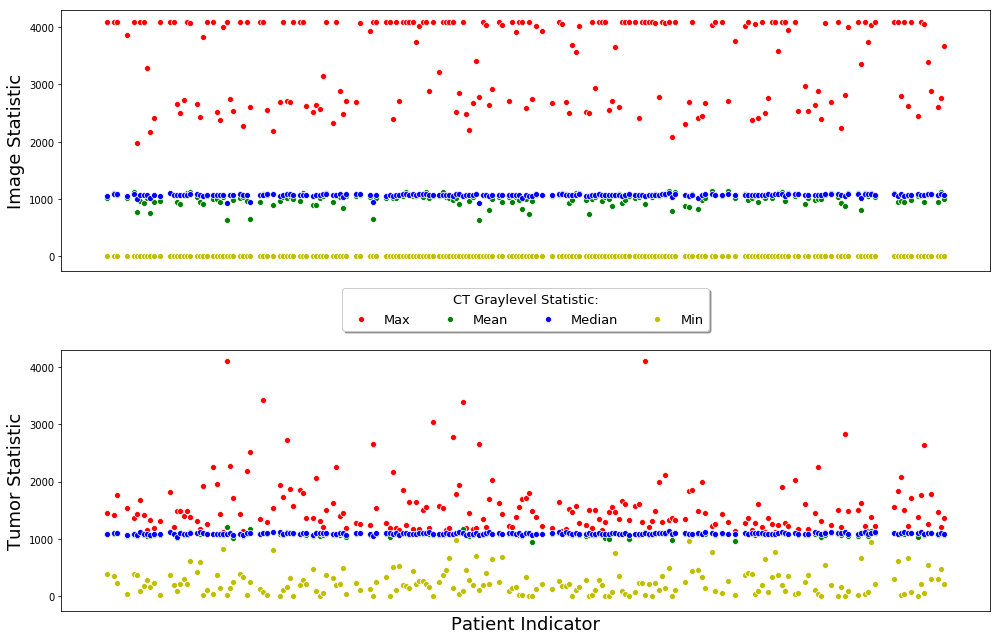

In [18]:
# Purpose:
# * Plot GL characteristics to detect anomalies and groupings.

# Observations: 
# * Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# * The difference between average max in the complete and cropped image illustrates the significant amount of 
#   artifacts in each image. 

# Plot CT image and tumor GL stats. 
rcParams['axes.prop_cycle'] = cycler(color=['r', 'g', 'b', 'y'])
fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Max', 'Mean', 'Median', 'Min']
for num, (ct_cropped_row_label, ct_row_label) in enumerate(zip(df_ct_cropped_stats.T, df_ct_stats.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_stats.columns.values), 
        y=np.squeeze(df_ct_stats.loc[ct_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(df_ct_cropped_stats.columns.values), 
        y=np.squeeze(df_ct_cropped_stats.loc[ct_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='CT Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=4, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './ct_gl_stats.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Inspecting images in CT max > 3000 group

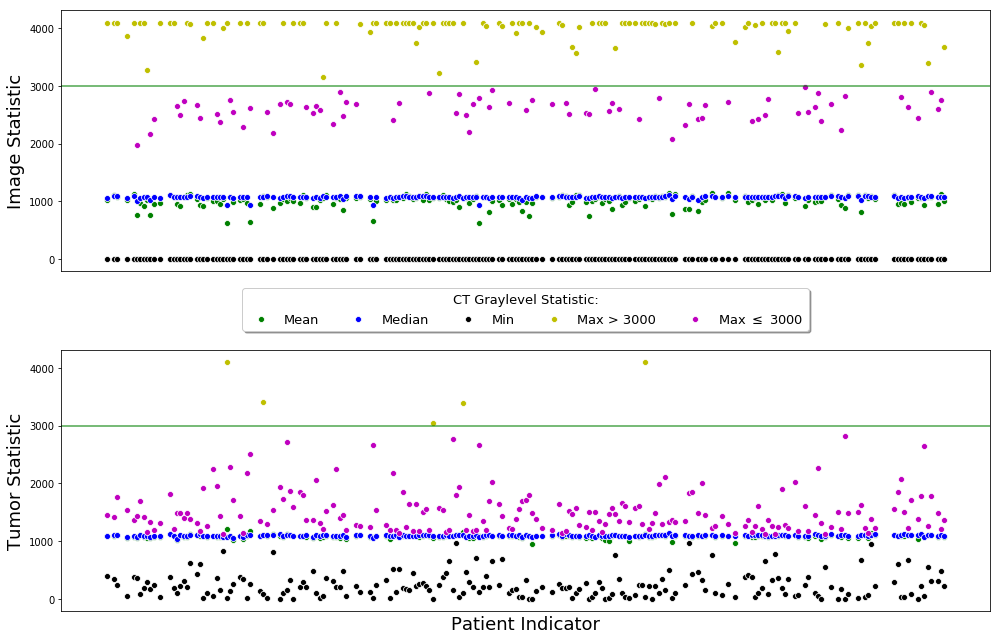

In [23]:
# Purpose:
# * Further investigate the difference betweeen images wrt. GL max values.

# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
rcParams['axes.prop_cycle'] = cycler(color=['g', 'b', 'k', 'y', 'm'])

thresh = 3000

# HACK:
_tmp = df_ct_stats.copy()
_tmp.loc['greater', :] = None
_tmp.loc['less', :] = None
less_idx = df_ct_stats.loc['gl_max', :] < thresh
greater_idx = df_ct_stats.loc['gl_max', :] >= thresh
_tmp.loc['less', less_idx] = df_ct_stats.loc['gl_max', less_idx]
_tmp.loc['greater', greater_idx] = df_ct_stats.loc['gl_max', greater_idx]
_tmp.drop('gl_max', inplace=True)

_tmp_cropped = df_ct_cropped_stats.copy()
_tmp_cropped.loc['greater', :] = None
_tmp_cropped.loc['less', :] = None
cropped_less_idx = df_ct_cropped_stats.loc['gl_max', :] < thresh
cropped_greater_idx = df_ct_cropped_stats.loc['gl_max', :] >= thresh
_tmp_cropped.loc['less', cropped_less_idx] = df_ct_cropped_stats.loc['gl_max', cropped_less_idx]
_tmp_cropped.loc['greater', cropped_greater_idx] = df_ct_cropped_stats.loc['gl_max', cropped_greater_idx]
_tmp_cropped.drop('gl_max', inplace=True)

fig, (image_axis, cropped_axis) = plt.subplots(
    nrows=2, sharex=True, figsize=(14, 9)
)
labels = ['Mean', 'Median', 'Min', r'Max > 3000', r'Max $\leq$ 3000']
for num, (ct_cropped_row_label, ct_row_label) in enumerate(zip(_tmp_cropped.T, _tmp.T)):
    # Plot image stats.
    sns.scatterplot(
        x=np.squeeze(_tmp.columns.values), 
        y=np.squeeze(_tmp.loc[ct_row_label, :].values),
        ax=image_axis,
    )
    # Plot tupr stats.
    sns.scatterplot(
        x=np.squeeze(_tmp_cropped.columns.values), 
        y=np.squeeze(_tmp_cropped.loc[ct_cropped_row_label, :].values),
        ax=cropped_axis,
        label=labels[num]
    )
cropped_axis.legend(
    title='CT Graylevel Statistic:',
    title_fontsize=13,
    fontsize=13, 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.26),
    ncol=5, 
    fancybox=True, 
    shadow=True
)
image_axis.set_ylabel('Image Statistic', fontsize=18)
cropped_axis.set_ylabel('Tumor Statistic', fontsize=18)
plt.xlabel('Patient Indicator', fontsize=18)
plt.xticks([])
image_axis.axhline(y=3000, alpha=0.7)
cropped_axis.axhline(y=3000, alpha=0.7)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)
plt.savefig(
    './max_groups_ct_gl.png',
    bbox_inches='tight',
    transparent=True,
    dpi=100, 
)

# Examples max > 3000 group

In [20]:
# 38: The majority of the tumor contains jaw bone, teeths and streaking artifacts.
# 49: Some slices with streak artifacts.
# 100: Some slices with streak artifacts.
# 109: Some slices with streak artifacts.
# 164: Some slices with streak artifacts.
_tmp_cropped.loc['greater'].dropna()

38     4094.677572
49     3413.780957
100    3038.741817
109    3395.597620
164    4094.937514
Name: greater, dtype: float64

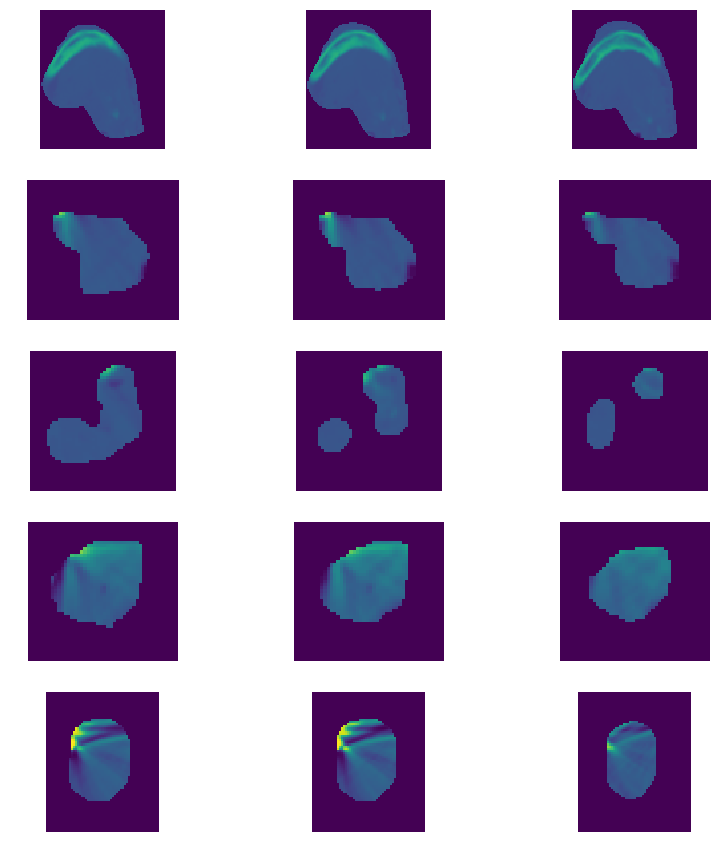

In [21]:
# Purpose:
# * What could be the cause of different max values? More artifacts?

# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.
# Selected slices from the four patients with max(I) > 3000.
images_to_plot = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 20:-10, 49],
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 20:-10, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'][15:-15, 20:-10, 52],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 49],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 50],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'][15:-15, 20:-10, 52],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 42],
    ct_cropped['./../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P100CT.nrrd'][15:-20, 15:-10, 50],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 47],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 48],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'][15:-15, 15:-10, 50],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 58],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 59],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'][15:-15, 15:-10, 61],
]
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))
for num, axis in enumerate(axes.ravel()):
    # Resize images to tumor volume region.
    axis.imshow(
        images_to_plot[num], 
        #cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    )
    vmin=np.min(images_to_plot[num]),
    vmax=np.max(images_to_plot[num])
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=0.2)
plt.tight_layout()

# Histograms examples max > 3000 group

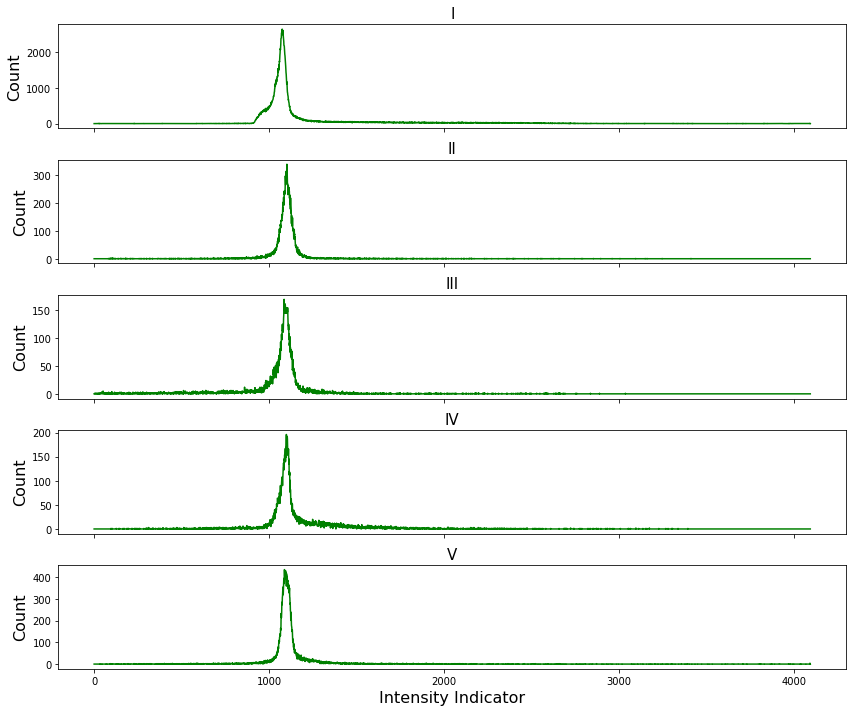

In [124]:
# Observations:
# * Histogram resembles dirac delta function (for not so small a param, see wiki).

imgs = [
    ct_cropped['./../../data_source/images/ct_nrrd/P038CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P049CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P100CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P109CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P164CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(nrows=len(imgs), figsize=(12, 10), sharex=True)
titles = ['I', 'II', 'III', 'IV', 'V']
for num, axis in enumerate(axes.ravel()):
    img = imgs[num]
    # NOTE: Skip background voxels.
    hist, _ = np.histogram(np.squeeze(img[img != 0].ravel()), bins=np.linspace(0, 2**12, 2**12))
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# Examples $\leq$ 3000 group

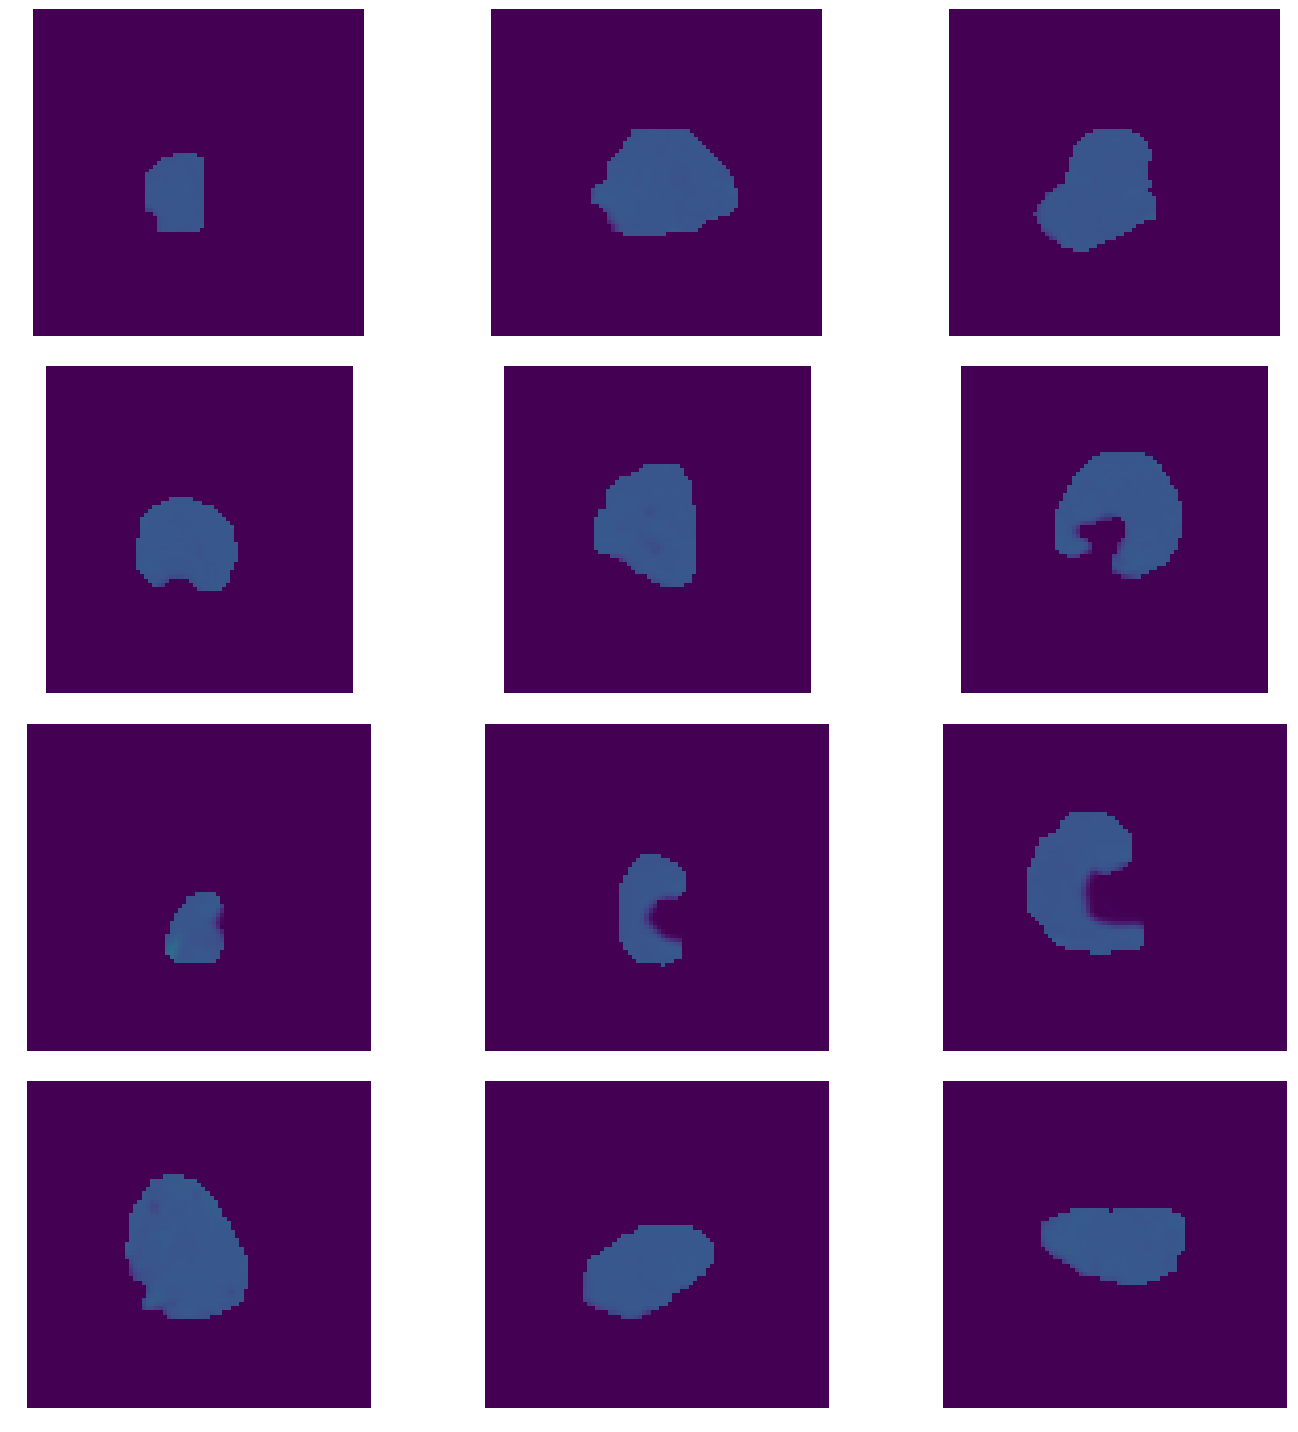

In [108]:
# NOTE: Bone thresholding reveals that max intensity values are caused by bone and streaking artifacts.

# Selected slices from the four patients with max(I) > 3000.

images_to_plot = [
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 21],
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 26],
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'][:, :, 32],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 25],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 35],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'][:, :, 45],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 25],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 37],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'][:, :, 55],
    
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 31],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 41],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'][:, :, 51],
]
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(20, 20))
for num, axis in enumerate(axes.ravel()):
    axis.imshow(
        images_to_plot[num], #cmap=plt.cm.gray,
        vmin=0,
        vmax=2**12,
    ),
    #axis.set_title(titles[num])
    axis.axis('off')   
#plt.subplots_adjust(wspace=0, hspace=0.2)
plt.tight_layout()

# Examples $\leq$ 3000 group

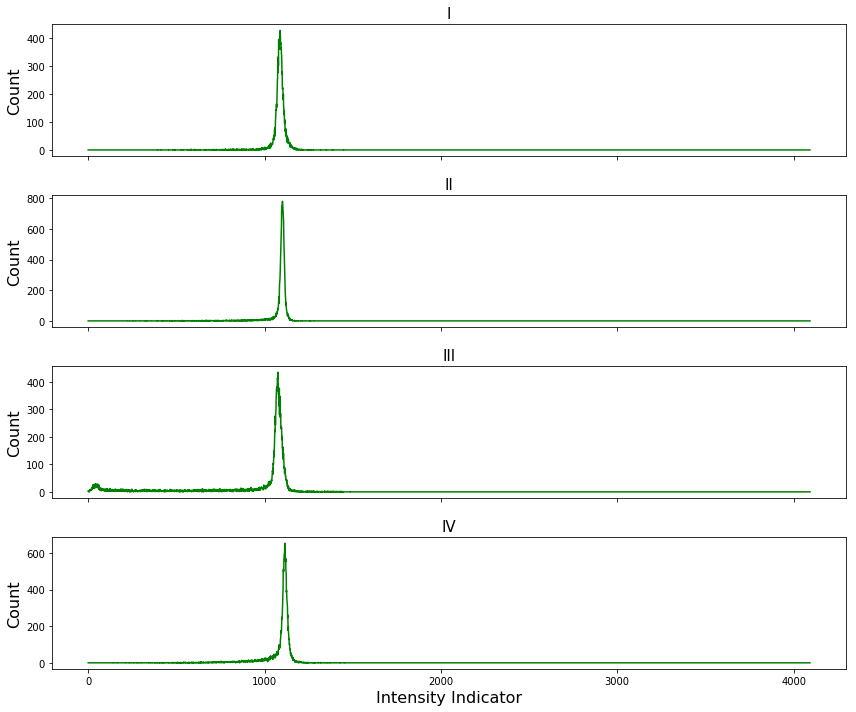

In [109]:
# Observations:
# * Histogram resembles dirac delta function (for not so small a param, see wiki).

imgs = [
    ct_cropped['./../../data_source/images/ct_nrrd/P002CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P077CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P130CT.nrrd'],
    ct_cropped['./../../data_source/images/ct_nrrd/P182CT.nrrd'],
]
# Try bins: 32, 64, 128 as in feature extraction.
fig, axes = plt.subplots(nrows=len(imgs), figsize=(12, 10), sharex=True)
titles = ['I', 'II', 'III', 'IV']
for num, axis in enumerate(axes.ravel()):
    hist, _ = np.histogram(np.squeeze(imgs[num].ravel()), bins=np.linspace(0, 2**12, 2**12))
    # NOTE: Skip background voxels.
    hist = hist[1:]
    axes[num].set_title(titles[num], fontsize=15)
    axes[num].plot(np.arange(np.size(hist)), np.squeeze(hist))
    axes[num].set_ylabel('Count', fontsize=16)
    
plt.xlabel('Intensity Indicator', fontsize=16)
plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

# CT Outliers by IBSI Definition

In [115]:
ct_cropped_std = []
for ct_image in ct_cropped.values():
    ct_cropped_std.append(np.std(ct_image[ct_image != 0]))
    
ct_cropped_std = np.array(ct_cropped_std)

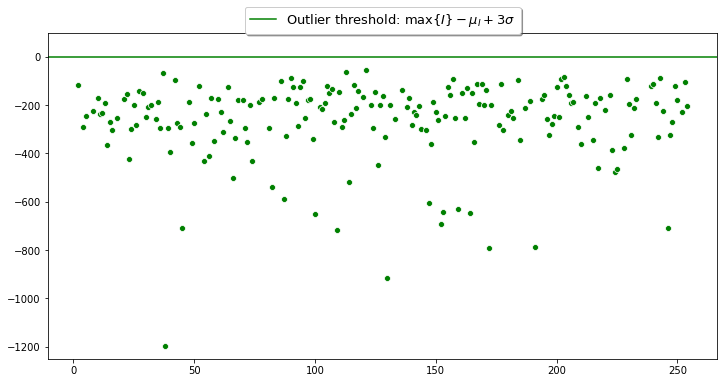

In [122]:
n = 3

df_ct_cropped_max = df_pet_stats.loc['gl_max', :].values
outliers = np.mean(df_ct_cropped_max) + n * ct_cropped_std

plt.figure(figsize=(12, 6))
sns.scatterplot(
    x=np.squeeze(df_pet_stats.columns.values), 
    y=np.squeeze(df_ct_cropped_max) - outliers,
)
plt.axhline(y=0)
plt.ylim([-1250, 100])
plt.legend(
    [r'Outlier threshold: $\max \left \{ I \right \} - \mu_{I} + 3 \sigma$'],
    title_fontsize=14,
    fontsize=13,
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.1),
    ncol=1, 
    fancybox=True, 
    shadow=True
)